## Jupyter notebook for plotting the correlations between CHi-C, ATAC-seq and RNA-seq

This notebook is the code for plotting the correlations between CHi-C, ATAC-seq and RNA-seq time course data used in the paper **"Simultaneous analysis of open chromatin, promoter interactions and gene expression in stimulated T cells implicates causal genes for rheumatoid arthritis"** by Jing Yang, Amanda McGovern, Paul Martin, Kate Duffus, Xiangyu Ge, Peyman Zarrineh, Andrew P Morris, Antony Adamson, Peter Fraser, Magnus Rattray & Stephen Eyre 

Author : *Jing Yang*  <br />
Date: 24-10-2019 <br />
For any questions about the code, please drop me a line at Jing.Yang@manchester.ac.uk

#### load packages

In [1]:
library(ggplot2)
library(reshape2)
library(ggsci)
library(tidyverse)
library(viridis)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: viridisLite



### load data 
load data between gene expression (RNA-seq) and open chromatin (ATAC-seq) connected by CHi-C interactions , ATAC-seq peaks in promoter regions are excluded from the study

In [2]:
set.seed(5)
data <- read.table(file='data/ATACseq_CHiC_RNAseq_linked.txt', header=T)


### separate data by the distance between baits and otherEnds

In [3]:
data$ATACpos <- 0.5*(data$ATACstart + data$ATACend)
data$otherEndpos <- 0.5*(data$otherEndstart + data$otherEndend)
data$baitpos <- 0.5*(data$baitstart + data$baitend)
data$ENSGpos <- 0.5*(data$ENSGstart + data$ENSGend)
data$dist_ATAC_gene <- abs(data$ATACpos - data$ENSGpos)
data$dist_otherEnd_bait <- abs(data$otherEndpos - data$baitpos)
data$dist_bait_gene <- abs(data$baitpos - data$ENSGpos)
data$dist_ATAC_bait <- abs(data$baitpos - data$ATACpos)


data_200k <- subset(data, data$dist_otherEnd_bait<200000)
data_500k <- subset(data, data$dist_otherEnd_bait<500000)
data_1MB <- subset(data, data$dist_otherEnd_bait<1000000)
data_5MB <- subset(data, data$dist_otherEnd_bait<5000000)
data_from200kto500k <- subset(data, (data$dist_otherEnd_bait>=200000) 
                                                          & (data$dist_otherEnd_bait<500000))
data_from500kto1MB <- subset(data, (data$dist_otherEnd_bait>=500000) 
                                                          & (data$dist_otherEnd_bait<1000000))
data_from1MBto5MB <- subset(data, (data$dist_otherEnd_bait>=1000000) 
                                                          & (data$dist_otherEnd_bait<5000000))

### get data ready for Fig. 4a

In [4]:
idx_atacseq <- c('AT0','AT20','AT1H','AT2H','AT4H','AT24H')
idx_atacseq_withID <- c('ATACchr','ATACstart','ATACend',idx_atacseq)
idx_gene <- c('ET0_a','ET20_a','ET1H_a','ET2H_a','ET4H_a','ET24H_a')
idx_gene_withID <- c('ENSG', idx_gene)
idx_chic <- c('T0','T20','T1H','T4H','T24H')
idx_chic_withID <- c('baitID','otherEndID', idx_chic)


In [5]:
atacseq_picked_200k <- unique(data_200k[,idx_atacseq_withID])
atacseq_picked_from200kto500k <- unique(data_from200kto500k[,idx_atacseq_withID])
atacseq_picked_from500kto1MB <- unique(data_from500kto1MB[,idx_atacseq_withID])
atacseq_picked_from1MBto5MB <- unique(data_from1MBto5MB[,idx_atacseq_withID])
atacseq_picked_5MB <- unique(data_5MB[,idx_atacseq_withID])
atacseq_picked_1MB <- unique(data_1MB[,idx_atacseq_withID])
atacseq_picked_500k <- unique(data_500k[,idx_atacseq_withID])

gene_picked_200k <- unique(data_200k[,idx_gene_withID])
gene_picked_from200kto500k <- unique(data_from200kto500k[,idx_gene_withID])
gene_picked_from500kto1MB <- unique(data_from500kto1MB[,idx_gene_withID])
gene_picked_from1MBto5MB <- unique(data_from1MBto5MB[,idx_gene_withID])
gene_picked_5MB <- unique(data_5MB[,idx_gene_withID])
gene_picked_1MB <- unique(data_1MB[,idx_gene_withID])
gene_picked_500k <- unique(data_500k[,idx_gene_withID])

chic_picked_200k <- unique(data_200k[,idx_chic_withID])
chic_picked_from200kto500k <- unique(data_from200kto500k[,idx_chic_withID])
chic_picked_from500kto1MB <- unique(data_from500kto1MB[,idx_chic_withID])
chic_picked_from1MBto5MB <- unique(data_from1MBto5MB[,idx_chic_withID])
chic_picked_5MB <- unique(data_5MB[,idx_chic_withID])
chic_picked_1MB <- unique(data_1MB[,idx_chic_withID])
chic_picked_500k <- unique(data_500k[,idx_chic_withID])


### creatae random background for the correltion density plots

In [6]:
N_5MB <- dim(data_5MB)[1]
N_1MB <- dim(data_1MB)[1]
N_500k <- dim(data_500k)[1]
N_200k <- dim(data_200k)[1]
N_from1MBto5MB <- dim(data_from1MBto5MB)[1]
N_from500kto1MB <- dim(data_from500kto1MB)[1]
N_from200kto500k <- dim(data_from200kto500k)[1]


In [7]:

idx_atac_200k_ind <- floor(runif(N_200k, 1,dim(atacseq_picked_200k)[1]))
idx_atac_from200kto500k_ind <- floor(runif(N_from200kto500k, 1,dim(atacseq_picked_from200kto500k)[1]))
idx_atac_from500kto1MB_ind <- floor(runif(N_from500kto1MB, 1,dim(atacseq_picked_from500kto1MB)[1]))
idx_atac_from1MBto5MB_ind <- floor(runif(N_from1MBto5MB, 1,dim(atacseq_picked_from1MBto5MB)[1]))
idx_atac_5MB_ind <- floor(runif(N_5MB, 1,dim(atacseq_picked_5MB)[1]))
idx_atac_1MB_ind <- floor(runif(N_1MB, 1,dim(atacseq_picked_1MB)[1]))
idx_atac_500k_ind <- floor(runif(N_500k, 1,dim(atacseq_picked_500k)[1]))

idx_gene_200k_ind <- floor(runif(N_200k, 1,dim(gene_picked_200k)[1]))
idx_gene_from200kto500k_ind <- floor(runif(N_from200kto500k, 1,dim(gene_picked_from200kto500k)[1]))
idx_gene_from500kto1MB_ind <- floor(runif(N_from500kto1MB, 1,dim(gene_picked_from500kto1MB)[1]))
idx_gene_from1MBto5MB_ind <- floor(runif(N_from1MBto5MB, 1,dim(gene_picked_from1MBto5MB)[1]))
idx_gene_5MB_ind <- floor(runif(N_5MB, 1,dim(gene_picked_5MB)[1]))
idx_gene_1MB_ind <- floor(runif(N_1MB, 1,dim(gene_picked_1MB)[1]))
idx_gene_500k_ind <- floor(runif(N_500k, 1,dim(gene_picked_500k)[1]))

idx_chic_200k_ind <- floor(runif(N_200k, 1,dim(chic_picked_200k)[1]))
idx_chic_from200kto500k_ind <- floor(runif(N_from200kto500k, 1,dim(chic_picked_from200kto500k)[1]))
idx_chic_from500kto1MB_ind <- floor(runif(N_from500kto1MB, 1,dim(chic_picked_from500kto1MB)[1]))
idx_chic_from1MBto5MB_ind <- floor(runif(N_from1MBto5MB, 1,dim(chic_picked_from1MBto5MB)[1]))
idx_chic_5MB_ind <- floor(runif(N_5MB, 1,dim(chic_picked_5MB)[1]))
idx_chic_1MB_ind <- floor(runif(N_1MB, 1,dim(chic_picked_1MB)[1]))
idx_chic_500k_ind <- floor(runif(N_500k, 1,dim(chic_picked_500k)[1]))


In [8]:
corr_aandg_random_200k_ind <- sapply(seq.int(N_200k),function(i) cor(t(atacseq_picked_200k[idx_atac_200k_ind[i],idx_atacseq]),t(gene_picked_200k[idx_gene_200k_ind[i],idx_gene])))
corr_aandg_random_from200kto500k_ind <- sapply(seq.int(N_from200kto500k),function(i) cor(t(atacseq_picked_from200kto500k[idx_atac_from200kto500k_ind[i],idx_atacseq]),t(gene_picked_from200kto500k[idx_gene_from200kto500k_ind[i],idx_gene])))
corr_aandg_random_from500kto1MB_ind <- sapply(seq.int(N_from500kto1MB),function(i) cor(t(atacseq_picked_from500kto1MB[idx_atac_from500kto1MB_ind[i],idx_atacseq]),t(gene_picked_from500kto1MB[idx_gene_from500kto1MB_ind[i],idx_gene])))
corr_aandg_random_from1MBto5MB_ind <- sapply(seq.int(N_from1MBto5MB),function(i) cor(t(atacseq_picked_from1MBto5MB[idx_atac_from1MBto5MB_ind[i],idx_atacseq]),t(gene_picked_from1MBto5MB[idx_gene_from1MBto5MB_ind[i],idx_gene])))
corr_aandg_random_5MB_ind <- sapply(seq.int(N_5MB),function(i) cor(t(atacseq_picked_5MB[idx_atac_5MB_ind[i],idx_atacseq]),t(gene_picked_5MB[idx_gene_5MB_ind[i],idx_gene])))
corr_aandg_random_1MB_ind <- sapply(seq.int(N_1MB),function(i) cor(t(atacseq_picked_1MB[idx_atac_1MB_ind[i],idx_atacseq]),t(gene_picked_1MB[idx_gene_1MB_ind[i],idx_gene])))
corr_aandg_random_500k_ind <- sapply(seq.int(N_500k),function(i) cor(t(atacseq_picked_500k[idx_atac_500k_ind[i],idx_atacseq]),t(gene_picked_500k[idx_gene_500k_ind[i],idx_gene])))


In [9]:
corr_aandOE_random_200k_ind <- sapply(seq.int(N_200k),function(i) cor(t(atacseq_picked_200k[idx_atac_200k_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_200k[idx_chic_200k_ind[i],idx_chic])))
corr_aandOE_random_from200kto500k_ind <- sapply(seq.int(N_from200kto500k),function(i) cor(t(atacseq_picked_from200kto500k[idx_atac_from200kto500k_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_from200kto500k[idx_chic_from200kto500k_ind[i],idx_chic])))
corr_aandOE_random_from500kto1MB_ind <- sapply(seq.int(N_from500kto1MB),function(i) cor(t(atacseq_picked_from500kto1MB[idx_atac_from500kto1MB_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_from500kto1MB[idx_chic_from500kto1MB_ind[i],idx_chic])))
corr_aandOE_random_from1MBto5MB_ind <- sapply(seq.int(N_from1MBto5MB),function(i) cor(t(atacseq_picked_from1MBto5MB[idx_atac_from1MBto5MB_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_from1MBto5MB[idx_chic_from1MBto5MB_ind[i],idx_chic])))
corr_aandOE_random_5MB_ind <- sapply(seq.int(N_5MB),function(i) cor(t(atacseq_picked_5MB[idx_atac_5MB_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_5MB[idx_chic_5MB_ind[i],idx_chic])))
corr_aandOE_random_1MB_ind <- sapply(seq.int(N_1MB),function(i) cor(t(atacseq_picked_1MB[idx_atac_1MB_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_1MB[idx_chic_1MB_ind[i],idx_chic])))
corr_aandOE_random_500k_ind <- sapply(seq.int(N_500k),function(i) cor(t(atacseq_picked_500k[idx_atac_500k_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_500k[idx_chic_500k_ind[i],idx_chic])))


In [10]:
corr_gandOE_random_200k_ind <- sapply(seq.int(N_200k),function(i) cor(t(gene_picked_200k[idx_gene_200k_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_200k[idx_chic_200k_ind[i],idx_chic])))
corr_gandOE_random_from200kto500k_ind <- sapply(seq.int(N_from200kto500k),function(i) cor(t(gene_picked_from200kto500k[idx_gene_from200kto500k_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_from200kto500k[idx_chic_from200kto500k_ind[i],idx_chic])))
corr_gandOE_random_from500kto1MB_ind <- sapply(seq.int(N_from500kto1MB),function(i) cor(t(gene_picked_from500kto1MB[idx_gene_from500kto1MB_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_from500kto1MB[idx_chic_from500kto1MB_ind[i],idx_chic])))
corr_gandOE_random_from1MBto5MB_ind <- sapply(seq.int(N_from1MBto5MB),function(i) cor(t(gene_picked_from1MBto5MB[idx_gene_from1MBto5MB_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_from1MBto5MB[idx_chic_from1MBto5MB_ind[i],idx_chic])))
corr_gandOE_random_5MB_ind <- sapply(seq.int(N_5MB),function(i) cor(t(gene_picked_5MB[idx_gene_5MB_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_5MB[idx_chic_5MB_ind[i],idx_chic])))
corr_gandOE_random_1MB_ind <- sapply(seq.int(N_1MB),function(i) cor(t(gene_picked_1MB[idx_gene_1MB_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_1MB[idx_chic_1MB_ind[i],idx_chic])))
corr_gandOE_random_500k_ind <- sapply(seq.int(N_500k),function(i) cor(t(gene_picked_500k[idx_gene_500k_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_500k[idx_chic_500k_ind[i],idx_chic])))


### plotting the correlation densities whthin different distance ranges

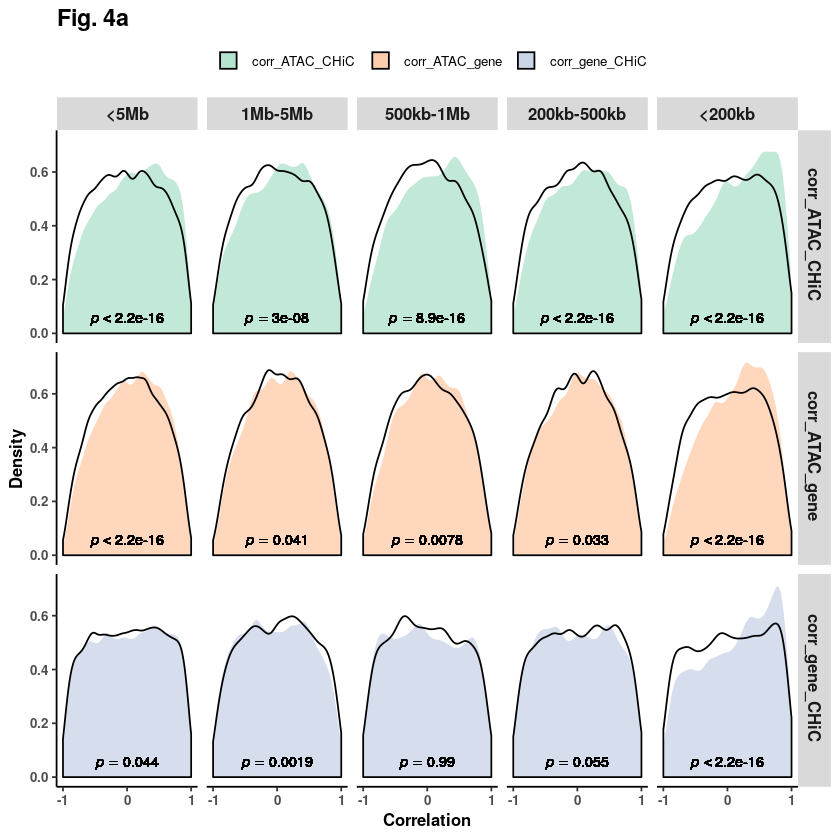

In [11]:
row0 <- dim(data_5MB)[1]
rowfrom1MBto5MB <- dim(data_from1MBto5MB)[1]
rowfrom500kto1MB <-dim(data_from500kto1MB)[1]
rowfrom200kto500k <- dim(data_from200kto500k)[1]
row200k <- dim(data_200k)[1]
row_all <- row0 + rowfrom1MBto5MB +rowfrom500kto1MB + rowfrom200kto500k + row200k
data_forplot <- data.frame( correlation=c(data_5MB$corr_atacseq_gene, 
   data_from1MBto5MB$corr_atacseq_gene, data_from500kto1MB$corr_atacseq_gene, 
   data_from200kto500k$corr_atacseq_gene, data_200k$corr_atacseq_gene, data_5MB$corr_atacseq_otherEnd, 
   data_from1MBto5MB$corr_atacseq_otherEnd, data_from500kto1MB$corr_atacseq_otherEnd, 
   data_from200kto500k$corr_atacseq_otherEnd, data_200k$corr_atacseq_otherEnd, data_5MB$corr_gene_otherEnd, 
   data_from1MBto5MB$corr_gene_otherEnd, data_from500kto1MB$corr_gene_otherEnd, 
   data_from200kto500k$corr_gene_otherEnd, data_200k$corr_gene_otherEnd), 
    
    label=rep(c('corr_ATAC_gene ','corr_ATAC_CHiC ','corr_gene_CHiC '), each=row_all), 
            category=rep(rep(c('<5Mb','1Mb-5Mb','500kb-1Mb','200kb-500kb','<200kb'), 
                             c(row0, rowfrom1MBto5MB, rowfrom500kto1MB, rowfrom200kto500k, row200k)),3),
            pvalue=c(rep(c("italic(p) < 2.2e-16","italic(p) == 0.041","italic(p) == 7.8e-03","italic(p) == 0.033","italic(p) < 2.2e-16"),
                     c(row0, rowfrom1MBto5MB, rowfrom500kto1MB, rowfrom200kto500k, row200k)),
                    rep(c("italic(p) < 2.2e-16","italic(p) == 3.0e-08","italic(p) == 8.9e-16","italic(p) < 2.2e-16","italic(p) < 2.2e-16"),
                     c(row0, rowfrom1MBto5MB, rowfrom500kto1MB, rowfrom200kto500k, row200k)),
                    rep(c("italic(p) == 0.044","italic(p) == 1.9e-03","italic(p) == 0.99","italic(p) == 0.055","italic(p) < 2.2e-16"),
                     c(row0, rowfrom1MBto5MB, rowfrom500kto1MB, rowfrom200kto500k, row200k)))
    )

data_forplot$category_f <- factor(data_forplot$category, levels=c('<5Mb','1Mb-5Mb','500kb-1Mb','200kb-500kb','<200kb'))

data_forplot2 <- data.frame(correlation_random = c(corr_aandg_random_5MB_ind, corr_aandg_random_from1MBto5MB_ind, 
                                                   corr_aandg_random_from500kto1MB_ind, corr_aandg_random_from200kto500k_ind, 
                                                   corr_aandg_random_200k_ind,
                                                   corr_aandOE_random_5MB_ind, corr_aandOE_random_from1MBto5MB_ind,
                                                   corr_aandOE_random_from500kto1MB_ind, corr_aandOE_random_from200kto500k_ind,
                                                   corr_aandOE_random_200k_ind,
                                                   corr_gandOE_random_5MB_ind, corr_gandOE_random_from1MBto5MB_ind,
                                                   corr_gandOE_random_from500kto1MB_ind, corr_gandOE_random_from200kto500k_ind,
                                                   corr_gandOE_random_200k_ind),
                    label=rep(c('corr_ATAC_gene ','corr_ATAC_CHiC ','corr_gene_CHiC '), each=row_all), 
                    category=rep(rep(c('<5Mb','1Mb-5Mb','500kb-1Mb','200kb-500kb','<200kb'), 
                             c(row0, rowfrom1MBto5MB, rowfrom500kto1MB, rowfrom200kto500k, row200k)),3))
data_forplot2$category_f <- factor(data_forplot2$category, levels=c('<5Mb','1Mb-5Mb','500kb-1Mb','200kb-500kb','<200kb'))

p0 <- ggplot() + geom_density(data=data_forplot , aes(x=correlation, fill=label), color='white', alpha=0.8)  +
geom_density(data=data_forplot2, aes(x=correlation_random), color='black', size=0.5, alpha=1.0) +
geom_text(data=data_forplot, aes(x=0.0,y=0.05, label=pvalue), color='black', parse=TRUE, size=3) +
 scale_x_continuous(breaks=c(-1.0,0.0,1.0), labels=c(-1.0,0.0,1.0)) +
#scale_fill_locuszoom() +
scale_fill_brewer(palette="Pastel2") + 
theme(panel.background = element_blank(), plot.title = element_text(face='bold', size=14),
      text=element_text(size=10),
         axis.title=element_text(size=10,face="bold"), axis.text=element_text(size=8,face="bold"), axis.line=element_line('black'),
      ,legend.title=element_blank(), legend.text=element_text(size=8), 
      legend.box.background = element_rect(size=3, color='NA'),
      legend.key.size = unit(0.4, "cm"), legend.spacing.x = unit(0.3, 'cm'),
      strip.text.x=element_text(siz=10, face='bold'), strip.text.y=element_text(size=10, face='bold'), legend.position="top") +
 xlab('Correlation') + ylab('Density') + ggtitle('Fig. 4a') +
facet_grid(label ~ category_f) #+ ggtitle('p value from Wilcox test')

p0
#ggsave('~/Dropbox (The University of Manchester)/IntegratingATAC-RNA-HiC/Individual_Figures_Files/CHiC_ATACSeq_gene/correlations_within_ranges_0210.pdf', p0)


In [12]:
dim(data)

[1] 37819    86

In [13]:
table(data_forplot$category)


     <200kb        <5Mb     1Mb-5Mb 200kb-500kb   500kb-1Mb 
      17817       71913       21447       20682       11967 

In [14]:
head(data_forplot2)

,correlation_random,label,category,category_f
,<dbl>,<fct>,<fct>,<fct>
1,0.59612057,corr_ATAC_gene,<5Mb,<5Mb
2,0.51732528,corr_ATAC_gene,<5Mb,<5Mb
3,0.26871400,corr_ATAC_gene,<5Mb,<5Mb
4,0.15940687,corr_ATAC_gene,<5Mb,<5Mb
5,-0.07660971,corr_ATAC_gene,<5Mb,<5Mb
6,-0.38255312,corr_ATAC_gene,<5Mb,<5Mb


In [15]:
table(data_forplot2$label)
table(data_forplot2$category)


corr_ATAC_CHiC  corr_ATAC_gene  corr_gene_CHiC  
          47942           47942           47942 


     <200kb        <5Mb     1Mb-5Mb 200kb-500kb   500kb-1Mb 
      17817       71913       21447       20682       11967 

In [16]:
data_forplot %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_gene') 


correlation,label,category,pvalue,category_f
<dbl>,<fct>,<fct>,<fct>,<fct>


In [18]:
data_sample1 <- data_forplot %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_gene ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_gene ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)
dim(data_sample1)
dim(data_sample2)
data_sample1 <- data_forplot %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_ATAC_gene ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_ATAC_gene ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random, alternative='two.sided')
dim(data_sample1)
dim(data_sample2)
data_sample1 <- data_forplot %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_ATAC_gene ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_ATAC_gene ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)
dim(data_sample1)
dim(data_sample2)
data_sample1 <- data_forplot %>% filter(category %in% '200kb-500kb' & label %in% 'corr_ATAC_gene ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '200kb-500kb' & label %in% 'corr_ATAC_gene ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '<200kb' & label %in% 'corr_ATAC_gene ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<200kb' & label %in% 'corr_ATAC_gene ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)



	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 301268227, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


[1] 23971     1

[1] 23971     1


	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 26058637, p-value = 0.04091
alternative hypothesis: true location shift is not equal to 0


[1] 7149    1

[1] 7149    1


	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 8229799, p-value = 0.007785
alternative hypothesis: true location shift is not equal to 0


[1] 3989    1

[1] 3989    1


	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 24261027, p-value = 0.0333
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 19419489, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [19]:
data_sample1 <- data_forplot %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '200kb-500kb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '200kb-500kb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '<200kb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<200kb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)



	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 315157446, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 26921494, p-value = 3.008e-08
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 8783124, p-value = 8.937e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 25691254, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 19821923, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [20]:
data_sample1 <- data_forplot %>% filter(category %in% '<5Mb' & label %in% 'corr_gene_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<5Mb' & label %in% 'corr_gene_CHiC ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_gene_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_gene_CHiC ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_gene_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_gene_CHiC ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '200kb-500kb' & label %in% 'corr_gene_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '200kb-500kb' & label %in% 'corr_gene_CHiC ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '<200kb' & label %in% 'corr_gene_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<200kb' & label %in% 'corr_gene_CHiC ') %>% select(correlation_random)
wilcox.test(data_sample1$correlation, data_sample2$correlation_random)



	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 290361818, p-value = 0.0436
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 24786758, p-value = 0.001874
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 7954381, p-value = 0.987
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 23315477, p-value = 0.05516
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  data_sample1$correlation and data_sample2$correlation_random
W = 19379408, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [ ]:
data_sample1 <- data_forplot %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_gene') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_gene') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_ATAC_gene') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_ATAC_gene') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_ATAC_gene') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_ATAC_gene') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '200kb-500kb' & label %in% 'corr_ATAC_gene') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '200kb-500kb' & label %in% 'corr_ATAC_gene') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '<200kb' & label %in% 'corr_ATAC_gene') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<200kb' & label %in% 'corr_ATAC_gene') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)

In [ ]:
data_sample1 <- data_forplot %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_CHiC') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_CHiC') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_ATAC_CHiC') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_ATAC_CHiC') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_ATAC_CHiC') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_ATAC_CHiC') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '200kb-500kb' & label %in% 'corr_ATAC_CHiC') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '200kb-500kb' & label %in% 'corr_ATAC_CHiC') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '<200kb' & label %in% 'corr_ATAC_CHiC') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<200kb' & label %in% 'corr_ATAC_CHiC') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)

In [ ]:
data_sample1 <- data_forplot %>% filter(category %in% '<5Mb' & label %in% 'corr_gene_CHiC') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<5Mb' & label %in% 'corr_gene_CHiC') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_gene_CHiC') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_gene_CHiC') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_gene_CHiC') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_gene_CHiC') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '200kb-500kb' & label %in% 'corr_gene_CHiC') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '200kb-500kb' & label %in% 'corr_gene_CHiC') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)
data_sample1 <- data_forplot %>% filter(category %in% '<200kb' & label %in% 'corr_gene_CHiC') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<200kb' & label %in% 'corr_gene_CHiC') %>% select(correlation_random)
ks.test(data_sample1$correlation, data_sample2$correlation_random)

### Plotting correlation densities for different distance thresholds

In [ ]:
row0 <- dim(data_5MB)[1]
row1MB <- dim(data_1MB)[1]
row500k <-dim(data_500k)[1]
row200k <- dim(data_200k)[1]
row_all <- row0 + row1MB +row500k + row200k
data_forplot <- data.frame( correlation=c(data_5MB$corr_atacseq_gene, 
   data_1MB$corr_atacseq_gene, data_500k$corr_atacseq_gene, 
   data_200k$corr_atacseq_gene, data_5MB$corr_atacseq_otherEnd, 
   data_1MB$corr_atacseq_otherEnd, data_500k$corr_atacseq_otherEnd, 
   data_200k$corr_atacseq_otherEnd, data_5MB$corr_gene_otherEnd, 
   data_1MB$corr_gene_otherEnd, data_500k$corr_gene_otherEnd, 
   data_200k$corr_gene_otherEnd),     
    label=rep(c('corr_ATAC_gene','corr_ATAC_CHiC','corr_gene_CHiC'), each=row_all), 
            category=rep(rep(c('dist<5MB','dist<1MB','dist<500KB','dist<200KB'), c(row0, row1MB, row500k, row200k)),3)
    )

data_forplot$category_f <- factor(data_forplot$category, levels=c('dist<5MB','dist<1MB','dist<500KB','dist<200KB'))

data_forplot2 <- data.frame(correlation_random = c(corr_aandg_random_5MB_ind, corr_aandg_random_1MB_ind, 
                                                   corr_aandg_random_500k_ind, corr_aandg_random_200k_ind, 
                                                   corr_aandOE_random_5MB_ind, corr_aandOE_random_1MB_ind,
                                                   corr_aandOE_random_500k_ind, corr_aandOE_random_200k_ind,
                                                   corr_gandOE_random_5MB_ind, corr_gandOE_random_1MB_ind,
                                                   corr_gandOE_random_500k_ind, corr_gandOE_random_200k_ind),
                    label=rep(c('corr_ATAC_gene','corr_ATAC_CHiC','corr_gene_CHiC'), each=4*N), 
                    category=rep(rep(c('dist<5MB','dist<1MB','dist<500KB','dist<200KB'), each=N)))
data_forplot2$category_f <- factor(data_forplot2$category, levels=c('dist<5MB','dist<1MB','dist<500KB','dist<200KB'))

ggplot() + geom_density(data=data_forplot , aes(x=correlation, fill=label), alpha=0.6)  +
geom_density(data=data_forplot2, aes(x=correlation_random, color='Background'), alpha=0.6) +
 scale_x_continuous(breaks=c(-1.0,0.0,1.0), labels=c(-1.0,0.0,1.0)) +

scale_fill_manual(values=c('corr_ATAC_gene'='lightblue','corr_ATAC_CHiC'='steelblue1','corr_gene_CHiC'='royalblue1',
                           'Background'='black')) +
theme(panel.background = element_blank(), plot.title = element_text(face='bold', size=14, hjust=-0.05, vjust=0.1),
         axis.title=element_text(size=12,face="bold"), axis.text=element_text(size=10), axis.line=element_line('black'),
      ,legend.title=element_blank(), legend.text=element_text(size=6), 
      legend.box.background = element_rect(size=3, color='NA'),
      legend.key.size = unit(0.4, "cm"), legend.spacing.x = unit(0.2, 'cm'),
      strip.text.x=element_text(siz=8, face='bold'), strip.text.y=element_text(size=6, face='bold'), legend.position="bottom") +
 xlab('Correlation') + ylab('Density') + ggtitle('Correltion density plots at different distance thresholds') +
facet_grid(label ~ category_f)

